# Import libraries and setup

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]='2'

import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append('waveglow/')

import matplotlib.pyplot as plt
%matplotlib inline

import IPython.display as ipd
import pickle as pkl
import torch
import hparams
from torch.utils.data import DataLoader
from model import Model
from text import text_to_sequence, sequence_to_text
from denoiser import Denoiser
from tqdm import tqdm_notebook as tqdm
import librosa

checkpoint_path = "training_log/waveglow_char/checkpoint_100000"

model = Model(hparams).cuda()
model.load_state_dict(torch.load(checkpoint_path)['state_dict'])
_ = model.cuda().eval()

# Data filtering

In [2]:
datasets = ['train', 'val', 'test']

for dataset in datasets:
    with open(f'filelists/ljs_audio_text_{dataset}_filelist.txt', 'r') as f:
        lines = [line.split('|') for line in f.read().splitlines()]

    for i in tqdm(range(len(lines))):
        file_name, _, text = lines[i]
        seq = os.path.join('/media/disk1/lyh/LJSpeech-1.1/waveglow',
                           'char_seq')
        mel = os.path.join('/media/disk1/lyh/LJSpeech-1.1/waveglow',
                           'melspectrogram')

        with open(f'{seq}/{file_name}_sequence.pkl', 'rb') as f:
            text_padded = pkl.load(f).unsqueeze(0)
        with open(f'{mel}/{file_name}_melspectrogram.pkl', 'rb') as f:
            mel_padded = pkl.load(f).unsqueeze(0)

        text_lengths=torch.LongTensor([text_padded.size(1)])
        mel_lengths=torch.LongTensor([mel_padded.size(2)])

        _, melspec, _, _, alignments, _ = model(text_padded.cuda(),
                                                mel_padded.cuda(),
                                                text_lengths.cuda(),
                                                mel_lengths.cuda())
        melspec = melspec[0]
        
        F = torch.mean(torch.max(alignments, dim=-1)[0], dim=-1)
        
        if F.max().item()>0.8:
            r, c = torch.argmax(F).item()//4, torch.argmax(F).item()%4
            with open(f'/media/disk1/lyh/fastspeech_char/targets/{file_name}.pkl', 'wb') as f:
                pkl.dump(melspec.detach().cpu(), f)
            with open(f'/media/disk1/lyh/fastspeech_char/alignments/{file_name}.pkl', 'wb') as f:
                pkl.dump(alignments[0, r,c].detach().cpu(), f)

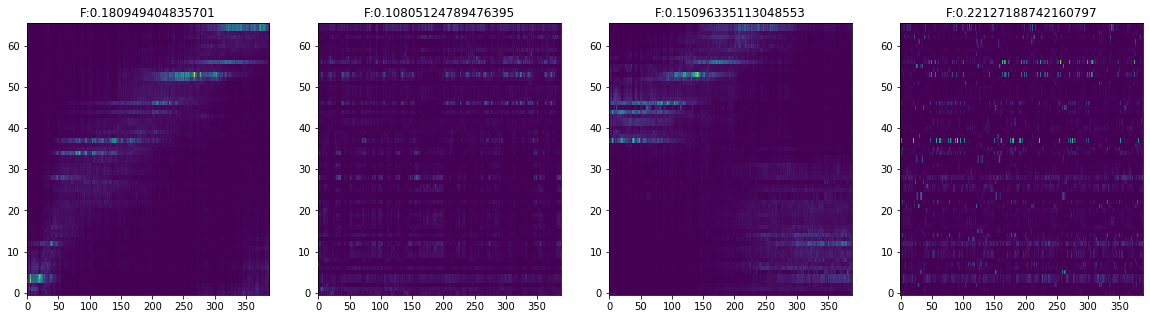

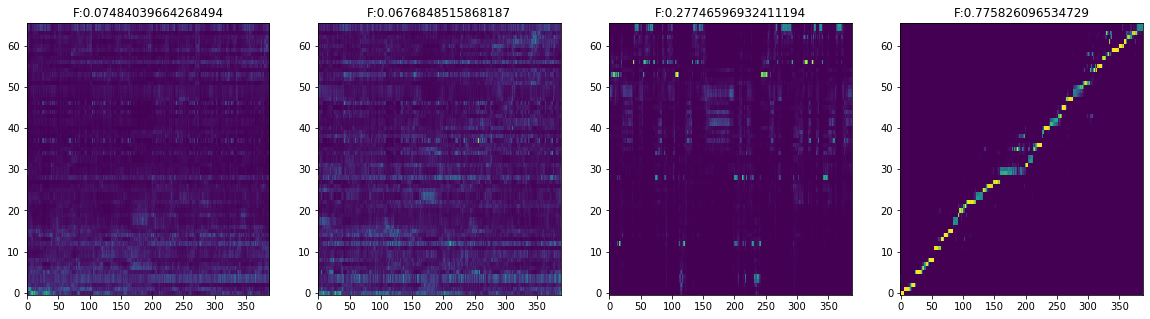

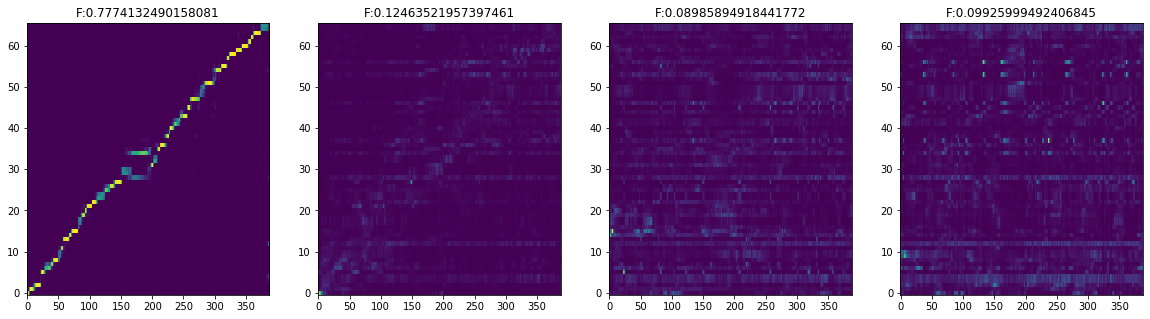

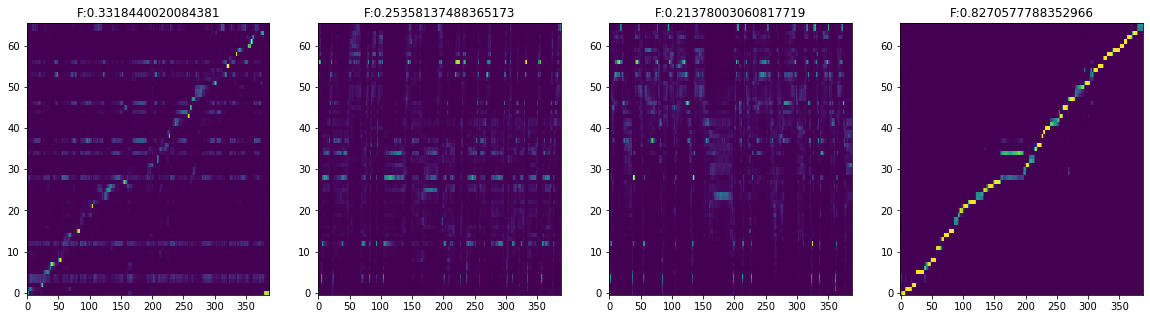

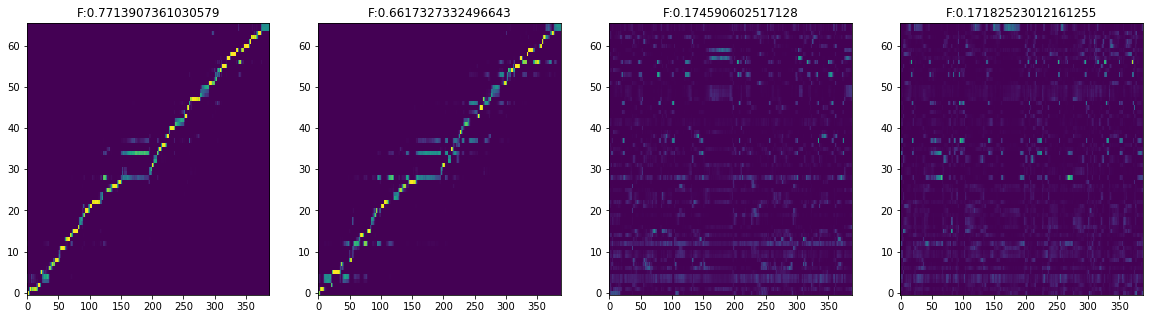

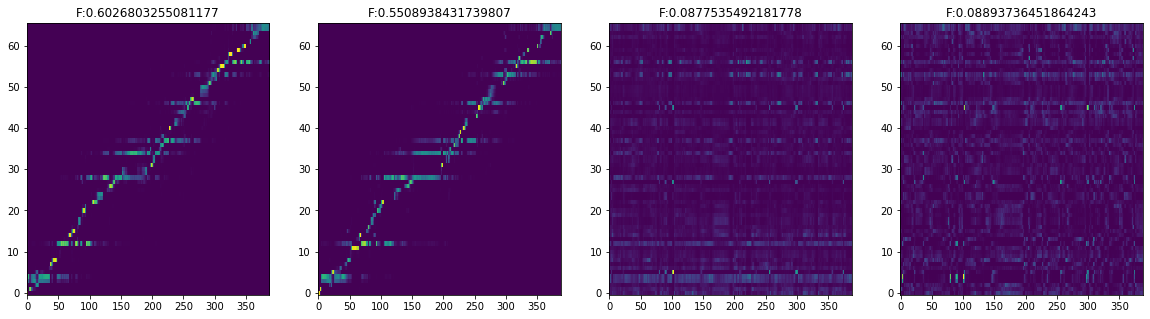

In [3]:
for i in range(6):
    fig, axes=plt.subplots(1,4, figsize=(20,5))
    for j in range(4):
        axes[j].imshow(alignments[0][i][j].detach().cpu().t(), origin='lower', aspect='auto')
        axes[j].set_title(f'F:{F[0,i,j]}')
    plt.show()